## Time series forecasting


# Initial setup

## Import required packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Import time series data: Global Superstore Dataset

In [2]:
data = pd.read_csv('Global+Superstore+Data.csv')

data['Order Date'] = pd.to_datetime(data['Order Date']).dt.to_period('m')

data = data.set_index('Order Date')

data.head()

Segment  Market     Sales    Profit
Order Date                                         
2012-07        Consumer      US  2309.650  762.1845
2013-05       Corporate    APAC  3709.395 -288.7650
2013-10        Consumer    APAC  5175.171  919.9710
2013-01     Home Office      EU  2892.510  -96.5400
2013-05        Consumer  Africa  2832.960  311.5200

# Time series analysis

## Here we combine market and segment in a single column called Market_Segment

In [3]:
data['Market_Segment'] = data[['Market', 'Segment']].apply(lambda x: '_'.join(x), axis=1)
data= data.drop(['Market','Segment'], 1)
data.head()

Sales    Profit   Market_Segment
Order Date                                     
2012-07     2309.650  762.1845      US_Consumer
2013-05     3709.395 -288.7650   APAC_Corporate
2013-10     5175.171  919.9710    APAC_Consumer
2013-01     2892.510  -96.5400   EU_Home Office
2013-05     2832.960  311.5200  Africa_Consumer

### Checking Missing values

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 51290 entries, 2012-07 to 2012-05
Freq: M
Data columns (total 3 columns):
Sales             51290 non-null float64
Profit            51290 non-null float64
Market_Segment    51290 non-null object
dtypes: float64(2), object(1)
memory usage: 1.6+ MB


##### We found that the data set donot have any missing values.

In [5]:
data.describe()

Sales        Profit
count  51290.000000  51290.000000
mean     246.490581     28.610982
std      487.565361    174.340972
min        0.444000  -6599.978000
25%       30.758625      0.000000
50%       85.053000      9.240000
75%      251.053200     36.810000
max    22638.480000   8399.976000

In [6]:
data['Market_Segment'].value_counts()

APAC_Consumer         5699
LATAM_Consumer        5321
US_Consumer           5191
EU_Consumer           5186
APAC_Corporate        3283
EU_Corporate          3077
LATAM_Corporate       3053
US_Corporate          3020
EMEA_Consumer         2538
Africa_Consumer       2381
APAC_Home Office      2020
LATAM_Home Office     1920
US_Home Office        1783
EU_Home Office        1737
EMEA_Corporate        1574
Africa_Corporate      1312
EMEA_Home Office       917
Africa_Home Office     894
Canada_Consumer        202
Canada_Corporate       110
Canada_Home Office      72
Name: Market_Segment, dtype: int64

### Finding Coefficient of Variation (CoV)

In [7]:


dataCOV= data.groupby(['Market_Segment'])['Profit'].std() / data.groupby(['Market_Segment'])['Profit'].mean()
dataCOV

Market_Segment
APAC_Consumer          4.206702
APAC_Corporate         4.231301
APAC_Home Office       4.633390
Africa_Consumer        7.351006
Africa_Corporate       9.334133
Africa_Home Office     6.264113
Canada_Consumer        2.093766
Canada_Corporate       2.767642
Canada_Home Office     3.175392
EMEA_Consumer         14.441103
EMEA_Corporate        22.038317
EMEA_Home Office      21.800527
EU_Consumer            4.718084
EU_Corporate           4.776482
EU_Home Office         4.923759
LATAM_Consumer         5.438845
LATAM_Corporate        5.789517
LATAM_Home Office      5.336331
US_Consumer            9.389450
US_Corporate           7.616929
US_Home Office         6.280008
Name: Profit, dtype: float64

In [8]:
data_profit=data.groupby('Market_Segment')['Profit'].mean().reset_index()
data_profit

Market_Segment     Profit
0        APAC_Consumer  39.097659
1       APAC_Corporate  39.517891
2     APAC_Home Office  41.309532
3      Africa_Consumer  20.063880
4     Africa_Corporate  15.767504
5   Africa_Home Office  22.832849
6      Canada_Consumer  47.909406
7     Canada_Corporate  45.786000
8   Canada_Home Office  43.100417
9        EMEA_Consumer  10.060116
10      EMEA_Corporate   7.941000
11    EMEA_Home Office   6.397233
12         EU_Consumer  36.384055
13        EU_Corporate  40.102041
14      EU_Home Office  34.972973
15      LATAM_Consumer  22.671102
16     LATAM_Corporate  18.956902
17   LATAM_Home Office  22.466216
18         US_Consumer  25.836873
19        US_Corporate  30.456667
20      US_Home Office  33.818664

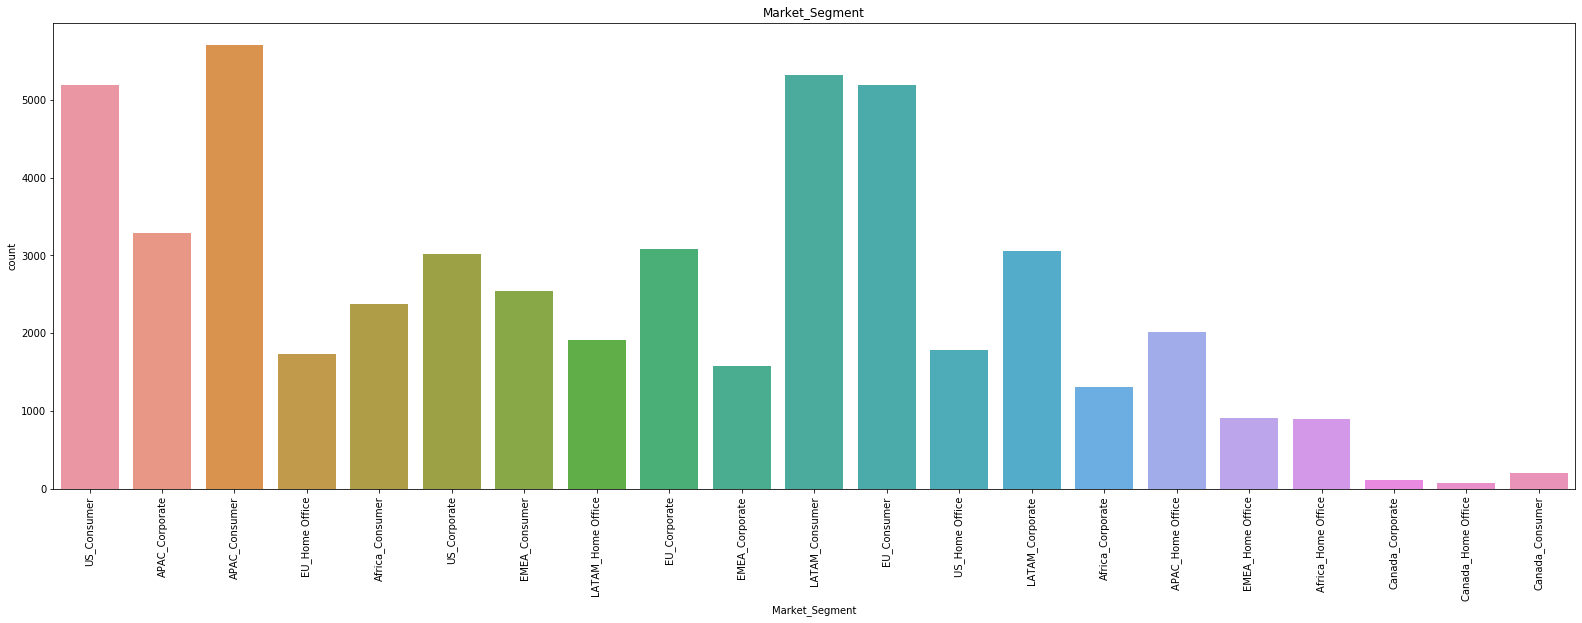

In [9]:
plt.figure(figsize = (60,60))
#plt.rcParams.update({'font.size': 22})
plt.subplot(6,2,1)
sns.countplot(data['Market_Segment']).tick_params(axis='x', rotation = 90)
plt.title('Market_Segment')
plt.show()

#### After finding COV and calculating most profitable market segment we found that APAC-Consumer has lowest COV value and highest profitable market segment .

### Dropping data for rest 20 market segment.

In [10]:

data = data[data.Market_Segment == 'APAC_Consumer']


In [11]:
data.describe()

Sales       Profit
count  5699.000000  5699.000000
mean    318.784646    39.097659
std     540.272454   164.472190
min       2.880000 -2380.350000
25%      46.542600    -2.877600
50%     121.920000    10.800000
75%     341.898300    46.800000
max    5759.964000  2817.990000

#### Grouping data based on Order Date and  finding sum of Sales

In [12]:
group_by_date= data.groupby('Order Date')

data_forecast = group_by_date['Sales'].sum().reset_index()

data_forecast = data_forecast.set_index('Order Date', drop=True)
data_forecast = data_forecast.to_timestamp()
data_forecast.head()

Sales
Order Date            
2011-01-01  18821.9898
2011-02-01  23313.3531
2011-03-01  26518.4919
2011-04-01  12046.0923
2011-05-01  25941.9000

#### We got the data for 48 months now.

In [13]:
data_forecast.shape

(48, 1)

## Outlier detection

### Box plot and interquartile range

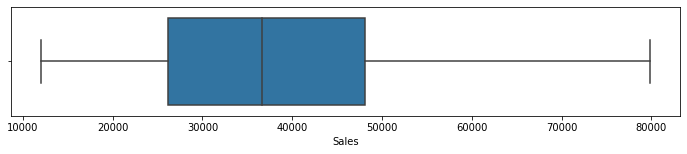

In [14]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=data_forecast['Sales'],whis=1.5)

### Histogram plot

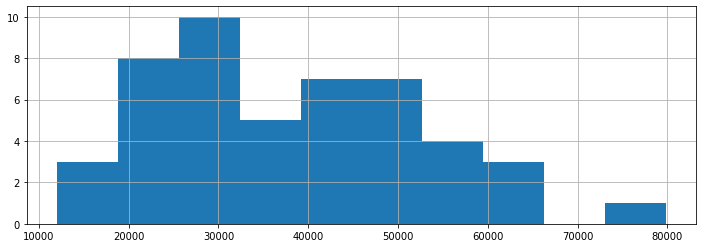

In [15]:
fig = data_forecast.Sales.hist(figsize = (12,4))

## Time series Decomposition

### Additive seasonal decomposition

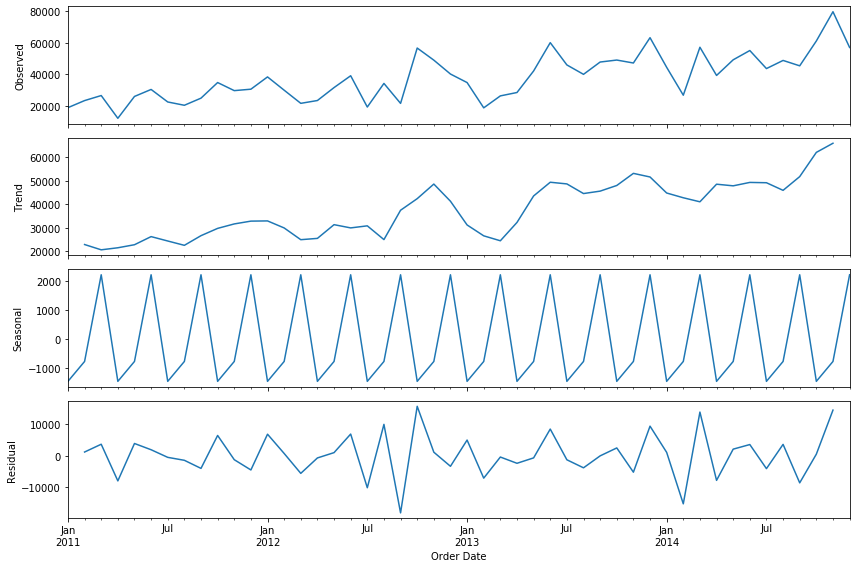

In [16]:
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
rcParams['figure.figsize'] = 12, 8

decomposition = sm.tsa.seasonal_decompose(data_forecast.Sales,freq=3, model='additive') # additive seasonal index

fig = decomposition.plot()
plt.show()

### Multiplicative seasonal decomposition


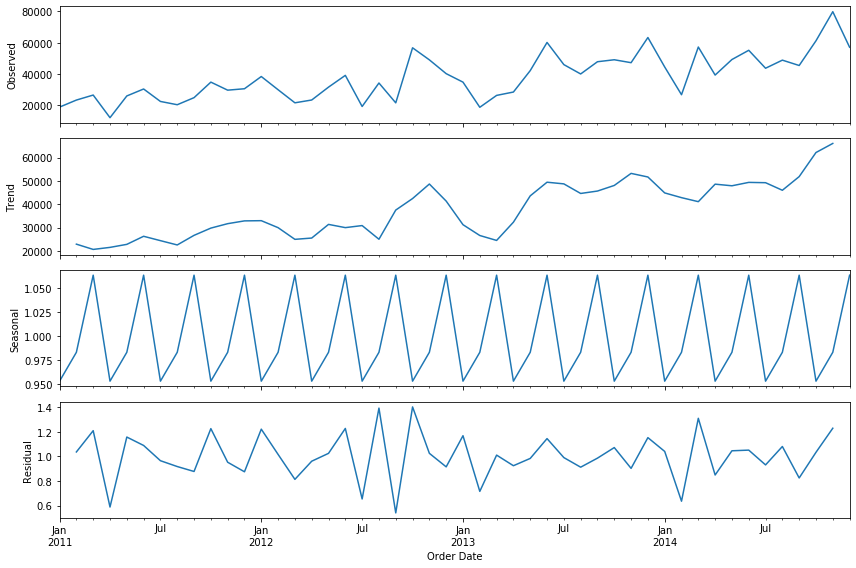

In [17]:
decomposition = sm.tsa.seasonal_decompose(data_forecast.Sales,freq=3, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

## Build and evaluate time series forecast

## Split time series data into training and test set

In [18]:
train_len = 42
train = data_forecast[0:train_len] 
test = data_forecast[train_len:] 

In [19]:
train.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42 entries, 2011-01-01 to 2014-06-01
Freq: MS
Data columns (total 1 columns):
Sales    42 non-null float64
dtypes: float64(1)
memory usage: 672.0 bytes


# Simple time series methods

## Naive method

In [20]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Sales'][train_len-1]

### Plot train, test and forecast

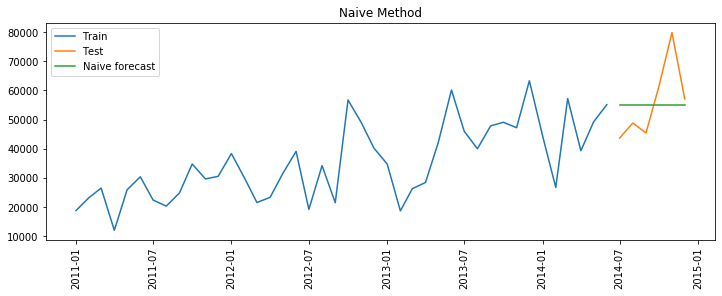

In [21]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.xticks(rotation=90)
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

### Calculate RMSE and MAPE

In [22]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_naive['naive_forecast'])/test['Sales'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

Method      RMSE   MAPE
0  Naive method  12355.97  17.47

## Simple average method

In [23]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Sales'].mean()

### Plot train, test and forecast

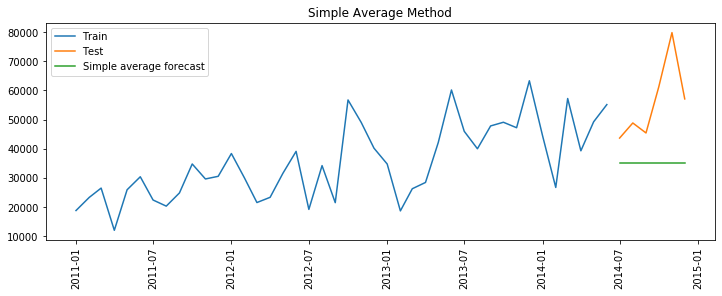

In [24]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

### Calculate RMSE and MAPE

In [25]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_avg['avg_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method      RMSE   MAPE
0           Naive method  12355.97  17.47
0  Simple average method  24146.06  34.34

## Simple moving average method

In [26]:
y_hat_sma = data_forecast.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = data_forecast['Sales'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

### Plot train, test and forecast

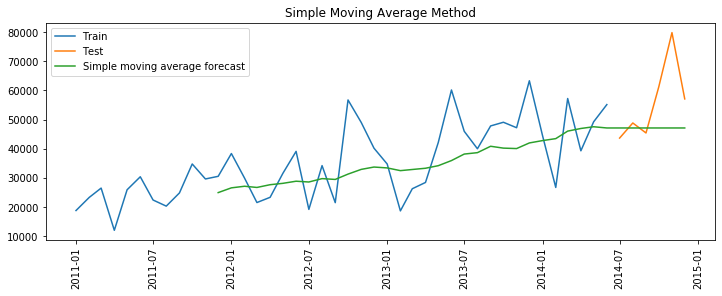

In [27]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.xticks(rotation=90)
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [28]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sma['sma_forecast'][train_len:])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method      RMSE   MAPE
0                    Naive method  12355.97  17.47
0           Simple average method  24146.06  34.34
0  Simple moving average forecast  15192.01  16.10

# Exponential smoothing methods

### Simple exponential smoothing

In [29]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Sales'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(6)

In [30]:
y_hat_ses['ses_forecast']

Order Date
2014-07-01    47448.096529
2014-08-01    47448.096529
2014-09-01    47448.096529
2014-10-01    47448.096529
2014-11-01    47448.096529
2014-12-01    47448.096529
Freq: MS, Name: ses_forecast, dtype: float64

### Plot train, test and forecast

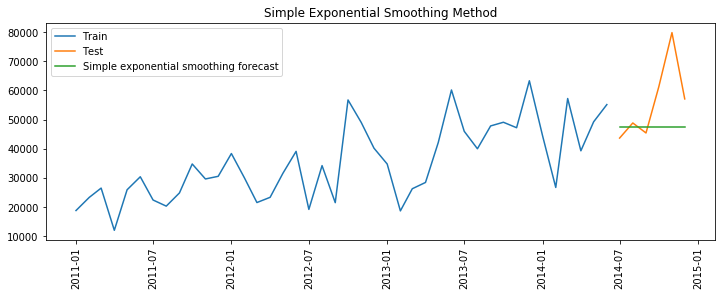

In [31]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.xticks(rotation=90)
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

### Calculate RMSE and MAPE

In [32]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ses['ses_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method      RMSE   MAPE
0                           Naive method  12355.97  17.47
0                  Simple average method  24146.06  34.34
0         Simple moving average forecast  15192.01  16.10
0  Simple exponential smoothing forecast  15011.49  15.99

## Holt's method with trend

In [33]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_slope': 0.01, 'smoothing_seasonal': None, 'damping_slope': nan, 'initial_level': 18821.989799999996, 'initial_slope': 4491.3633000000045, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

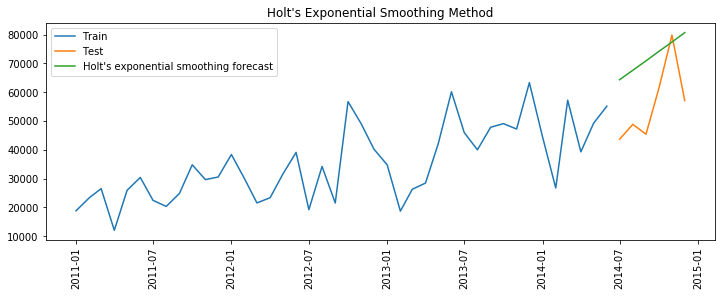

In [34]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.xticks(rotation=90)
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

### Calculate RSME and MAPE

In [35]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_holt['holt_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method      RMSE   MAPE
0                           Naive method  12355.97  17.47
0                  Simple average method  24146.06  34.34
0         Simple moving average forecast  15192.01  16.10
0  Simple exponential smoothing forecast  15011.49  15.99
0    Holt's exponential smoothing method  18976.37  34.57

## Holt Winters' additive method with trend and seasonality

In [36]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(6)

{'smoothing_level': 0.0001589669516769991, 'smoothing_slope': 0.0001589634465628399, 'smoothing_seasonal': 0.0, 'damping_slope': nan, 'initial_level': 30098.128863938822, 'initial_slope': 706.4480227671595, 'initial_seasons': array([ -9376.90367465, -19670.93673497, -12143.17512827, -19934.58098928,
        -9267.46276557,  -1002.58463365, -14271.92730198, -12910.99936781,
       -13416.83029752,   1031.7725666 ,  -4569.49935944,  -2637.79674903]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

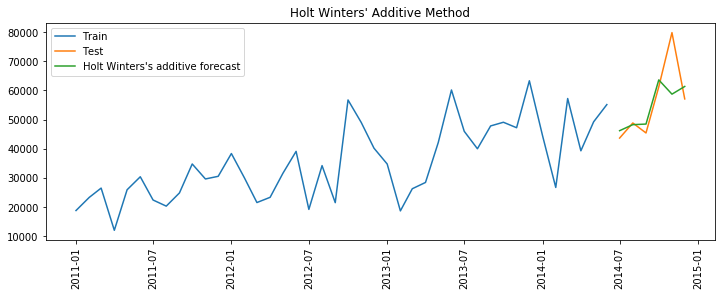

In [37]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.xticks(rotation=90)
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

### Calculate RMSE and MAPE

In [38]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwa['hw_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method      RMSE   MAPE
0                           Naive method  12355.97  17.47
0                  Simple average method  24146.06  34.34
0         Simple moving average forecast  15192.01  16.10
0  Simple exponential smoothing forecast  15011.49  15.99
0    Holt's exponential smoothing method  18976.37  34.57
0          Holt Winters' additive method   8994.00   8.59

## Holt Winter's multiplicative method with trend and seasonality

In [39]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(6)

{'smoothing_level': 2.4246805508010233e-08, 'smoothing_slope': 2.2789607342325968e-08, 'smoothing_seasonal': 7.329220477159925e-08, 'damping_slope': nan, 'initial_level': 34110.96530647067, 'initial_slope': 730.4171503865401, 'initial_seasons': array([0.71585326, 0.48620509, 0.682037  , 0.53147223, 0.73796092,
       0.90143417, 0.62469806, 0.65703816, 0.64896026, 0.93177386,
       0.82774596, 0.88436913]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot train, test and forecast

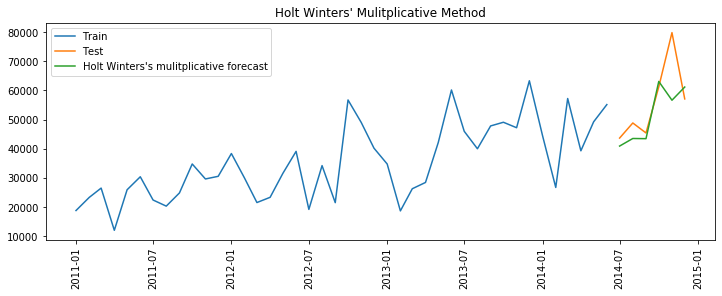

In [40]:
plt.figure(figsize=(12,4))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.xticks(rotation=90)
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

### Calculate RMSE and MAPE

In [41]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwm['hw_forecast'])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method      RMSE   MAPE
0                           Naive method  12355.97  17.47
0                  Simple average method  24146.06  34.34
0         Simple moving average forecast  15192.01  16.10
0  Simple exponential smoothing forecast  15011.49  15.99
0    Holt's exponential smoothing method  18976.37  34.57
0          Holt Winters' additive method   8994.00   8.59
0    Holt Winters' multiplicative method   9976.52  10.12

# Auto Regressive methods

## Stationarity vs non-stationary time series

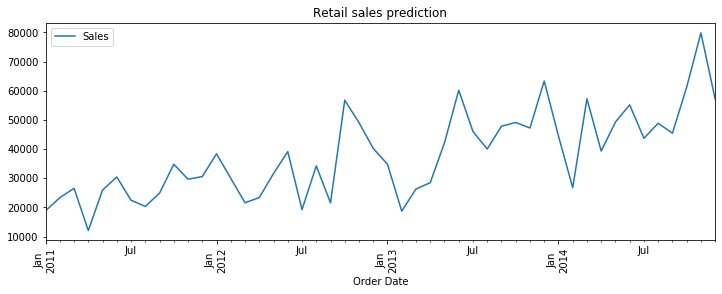

In [42]:
data_forecast['Sales'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Retail sales prediction')
plt.xticks(rotation=90)
plt.show(block=False)

### Augmented Dickey-Fuller (ADF) test

In [43]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data_forecast['Sales'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.376024
Critical Values @ 0.05: -2.93
p-value: 0.011804


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [44]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data_forecast['Sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.577076
Critical Values @ 0.05: 0.46
p-value: 0.024720


### Box Cox transformation to make variance constant

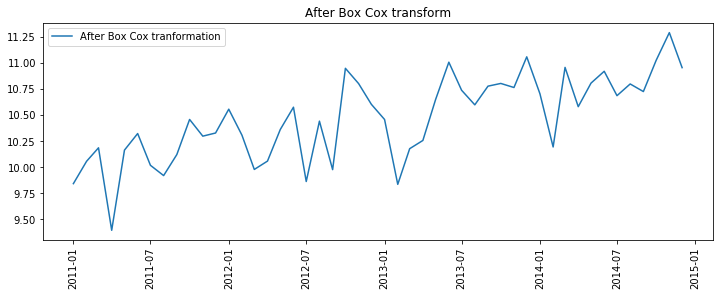

In [45]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data_forecast['Sales'], lmbda=0), index = data_forecast.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

### Differencing to remove trend

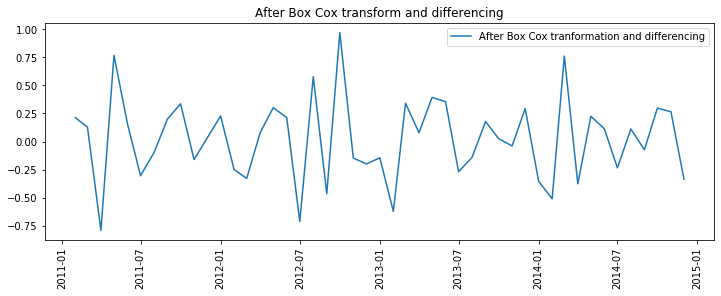

In [46]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data_forecast.index)
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [47]:
data_boxcox_diff.dropna(inplace=True)

In [48]:
data_boxcox_diff.tail()

Order Date
2014-08-01    0.112012
2014-09-01   -0.072673
2014-10-01    0.298459
2014-11-01    0.265449
2014-12-01   -0.335151
Freq: MS, dtype: float64

### Augmented Dickey-Fuller (ADF) test

In [49]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.535011
Critical Values @ 0.05: -2.95
p-value: 0.000170


### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [50]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.156456
Critical Values @ 0.05: 0.46
p-value: 0.100000


In [51]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [52]:
train_data_boxcox_diff.head()

Order Date
2011-02-01    0.214000
2011-03-01    0.128816
2011-04-01   -0.789102
2011-05-01    0.767119
2011-06-01    0.158548
Freq: MS, dtype: float64

## Auto regression method (AR)

In [53]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const      0.024255
ar.L1.y   -0.406729
dtype: float64


### Recover original time series

In [54]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

### Plot train, test and forecast

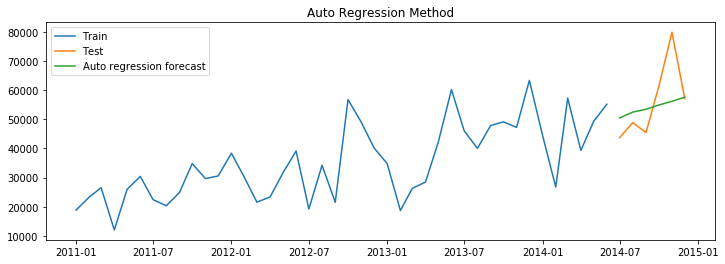

In [55]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

### Calculate RMSE and MAPE

In [56]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method      RMSE   MAPE
0                           Naive method  12355.97  17.47
0                  Simple average method  24146.06  34.34
0         Simple moving average forecast  15192.01  16.10
0  Simple exponential smoothing forecast  15011.49  15.99
0    Holt's exponential smoothing method  18976.37  34.57
0          Holt Winters' additive method   8994.00   8.59
0    Holt Winters' multiplicative method   9976.52  10.12
0             Autoregressive (AR) method  10985.28  13.56

## Moving average method (MA)

In [57]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      0.021415
ma.L1.y   -1.000000
dtype: float64


### Recover original time series

In [58]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

### Plot train, test and forecast

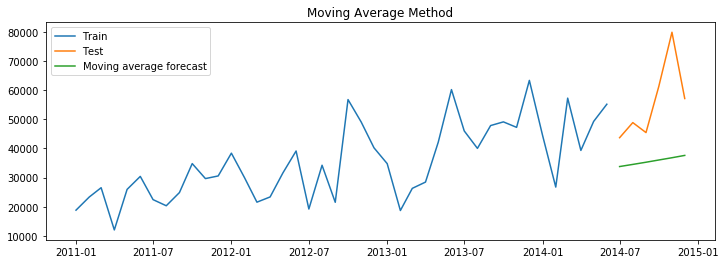

In [59]:
plt.figure(figsize=(12,4))
plt.plot(data_forecast['Sales'][:train_len], label='Train')
plt.plot(data_forecast['Sales'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

### Calculate RMSE and MAPE

In [60]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ma['ma_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method      RMSE   MAPE
0                           Naive method  12355.97  17.47
0                  Simple average method  24146.06  34.34
0         Simple moving average forecast  15192.01  16.10
0  Simple exponential smoothing forecast  15011.49  15.99
0    Holt's exponential smoothing method  18976.37  34.57
0          Holt Winters' additive method   8994.00   8.59
0    Holt Winters' multiplicative method   9976.52  10.12
0             Autoregressive (AR) method  10985.28  13.56
0             Moving Average (MA) method  23360.02  33.93

## Auto regression moving average method (ARMA)

In [61]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const      0.02147
ar.L1.y    0.07458
ma.L1.y   -1.00000
dtype: float64


### Recover original time series

In [62]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plot train, test and forecast

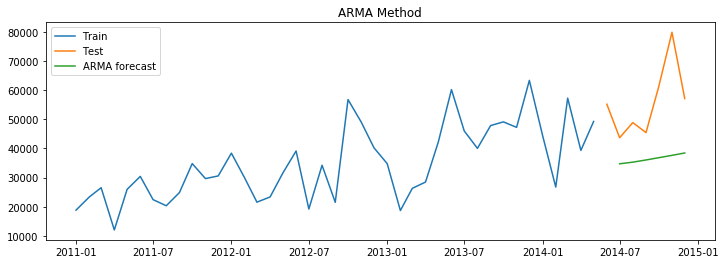

In [63]:
plt.figure(figsize=(12,4))
plt.plot( data_forecast['Sales'][:train_len-1], label='Train')
plt.plot(data_forecast['Sales'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

### Calculate RMSE and MAPE

In [64]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arma['arma_forecast'][train_len-1:])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method      RMSE   MAPE
0                                 Naive method  12355.97  17.47
0                        Simple average method  24146.06  34.34
0               Simple moving average forecast  15192.01  16.10
0        Simple exponential smoothing forecast  15011.49  15.99
0          Holt's exponential smoothing method  18976.37  34.57
0                Holt Winters' additive method   8994.00   8.59
0          Holt Winters' multiplicative method   9976.52  10.12
0                   Autoregressive (AR) method  10985.28  13.56
0                   Moving Average (MA) method  23360.02  33.93
0  Autoregressive moving average (ARMA) method  22654.32  32.40

## Auto regressive integrated moving average (ARIMA)

In [65]:
model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

const        0.02147
ar.L1.D.y    0.07458
ma.L1.D.y   -1.00000
dtype: float64


### Recover original time series forecast

In [66]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plot train, test and forecast

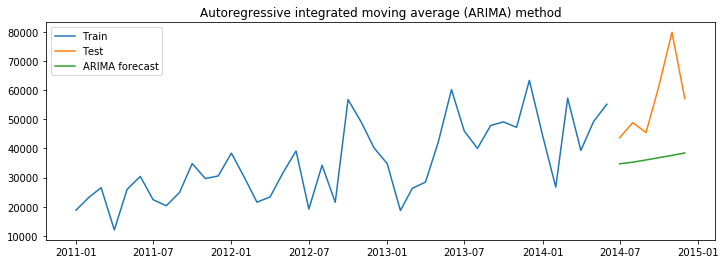

In [67]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [68]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arima['arima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method      RMSE   MAPE
0                                       Naive method  12355.97  17.47
0                              Simple average method  24146.06  34.34
0                     Simple moving average forecast  15192.01  16.10
0              Simple exponential smoothing forecast  15011.49  15.99
0                Holt's exponential smoothing method  18976.37  34.57
0                      Holt Winters' additive method   8994.00   8.59
0                Holt Winters' multiplicative method   9976.52  10.12
0                         Autoregressive (AR) method  10985.28  13.56
0                         Moving Average (MA) method  23360.02  33.93
0        Autoregressive moving average (ARMA) method  22654.32  32.40
0  Autoregressive integrated moving average (ARIM...  22654.32  32.40

## Seasonal auto regressive integrated moving average (SARIMA)

In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1      -0.039748
ma.L1      -0.994216
ar.S.L12   -0.485844
sigma2      0.082144
dtype: float64


### Recover original time series forecast

In [70]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train, test and forecast

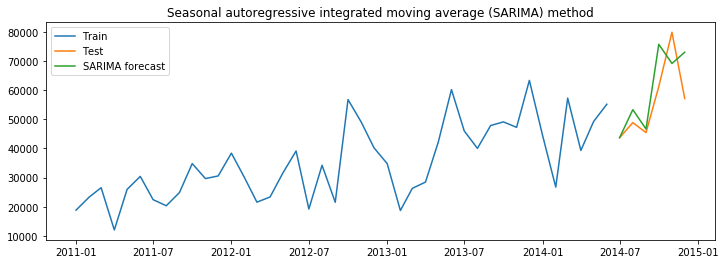

In [71]:
plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

### Calculate RMSE and MAPE

In [72]:
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

Method      RMSE   MAPE
0                                       Naive method  12355.97  17.47
0                              Simple average method  24146.06  34.34
0                     Simple moving average forecast  15192.01  16.10
0              Simple exponential smoothing forecast  15011.49  15.99
0                Holt's exponential smoothing method  18976.37  34.57
0                      Holt Winters' additive method   8994.00   8.59
0                Holt Winters' multiplicative method   9976.52  10.12
0                         Autoregressive (AR) method  10985.28  13.56
0                         Moving Average (MA) method  23360.02  33.93
0        Autoregressive moving average (ARMA) method  22654.32  32.40
0  Autoregressive integrated moving average (ARIM...  22654.32  32.40
0  Seasonal autoregressive integrated moving aver...   9985.98  12.78


#### From above we can conclude that best forecasting method in the smoothing technique is Holt Winters' additive method and the ARIMA set of techniques Seasonal auto regressive integrated moving average (SARIMA) as both have lowest MAPE value.